In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid")

In [26]:
df = pd.read_csv('../Data Source/final_merge.csv')

In [51]:
primary_dv = [
    'brfss_diabetes_ageadjprv' 
]
dv_struct = [
    'pct_dg_bb_int'
]
structural = [
    'bb_int_struct', #Social Policies | Soceieconomic and Political Context
    'pct_sex_male', #SES | Demographics 
    #'pct_sex_female', #SES | Demographics Commented out as reference
    #'pct_ed_lt9', #SES | Education Commented out as reference
    'pct_ed_9_12', #SES | Education
    'pct_ed_hs', #SES | Education
    'pct_ed_sc', #SES | Education
    'pct_ed_asc', #SES | Education
    'pct_ed_b', #SES | Education
    'pct_ed_gr', #SES | Education
    'pct_race_white', #SES | Demographics
    'pct_race_black', #SES | Demographics
    'pct_race_aian', #SES | Demographics
    'pct_race_asian', #SES | Demographics
    'pct_race_nhopi', #SES | Demographics
    'pct_race_other', #SES | Demographics
    #'pct_occ_unemp', #SES | Occupation
    'pct_occ_mgt', #SES | Occupation
    'pct_occ_svc', #SES | Occupation
    'pct_occ_sales', #SES | Occupation
    'pct_occ_nat_res', #SES | Occupation
    'pct_occ_prod', #SES | Occupation
    'pct_ses_pov', #SES | Income
    #'ruca_metro', #SES | Geography Commented out as reference
    'ruca_micro', #SES | Geography
    'ruca_small_town', #SES | Geography
    'ruca_rural' #SES | Geography
]


                            OLS Regression Results                            
Dep. Variable:          pct_dg_bb_int   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     209.7
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:07:17   Log-Likelihood:                -9205.2
No. Observations:                3076   AIC:                         1.846e+04
Df Residuals:                    3052   BIC:                         1.860e+04
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              80.4906      0.087    9

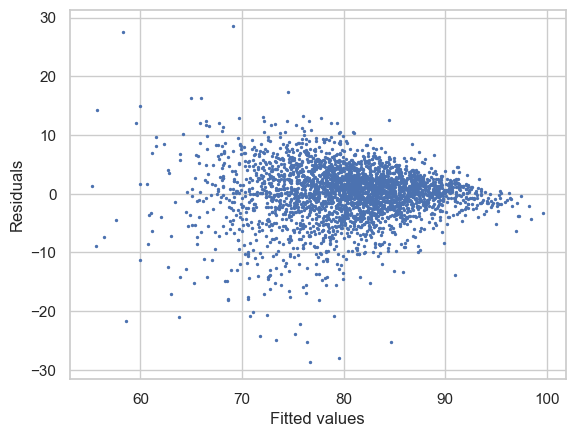

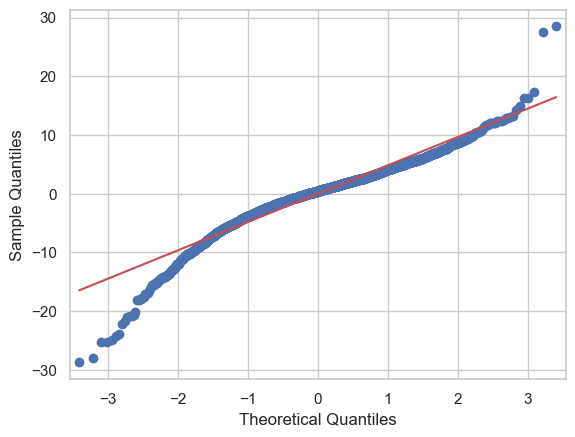

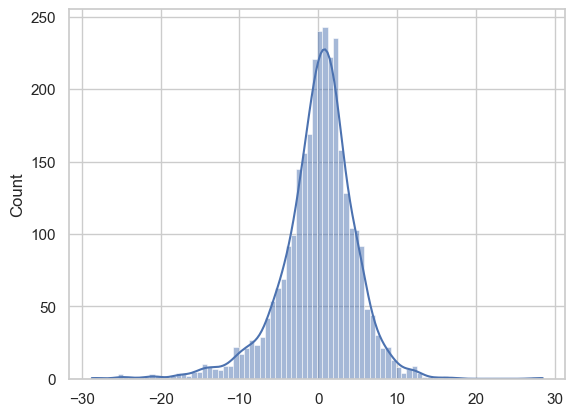

Mean Absolute Error: 3.441967682111237
Root Mean Squared Error: 4.824292309343361


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,80.491,0.087,921.731,"80.319 , 80.662",80.319,80.662
1,bb_int_struct,0.064,0.008,7.962,"0.048 , 0.08",0.048,0.08
2,pct_sex_male,0.058,0.056,1.043,"-0.051 , 0.167",-0.051,0.167
3,pct_ed_9_12,0.055,0.098,0.561,"-0.137 , 0.247",-0.137,0.247
4,pct_ed_hs,0.170,0.061,2.795,"0.051 , 0.288",0.051,0.288
5,pct_ed_sc,0.320,0.057,5.587,"0.208 , 0.432",0.208,0.432
6,pct_ed_asc,0.354,0.076,4.685,"0.206 , 0.502",0.206,0.502
7,pct_ed_b,0.430,0.066,6.516,"0.301 , 0.56",0.301,0.56
8,pct_ed_gr,0.430,0.069,6.254,"0.296 , 0.565",0.296,0.565
9,pct_race_white,-0.117,0.046,-2.546,"-0.207 , -0.027",-0.207,-0.027


PermissionError: [Errno 13] Permission denied: '../Data Source/structural_internet_adoption_results.csv'

In [52]:
X_struct = df[structural]
X_struct = X_struct - X_struct.mean()
X_struct = sm.add_constant(X_struct)

y = df[dv_struct]
#OLS with HC1 robust standard errors
model = sm.OLS(y, X_struct).fit(cov_type='HC1')

df['structural_internet_adoption'] = model.predict(X_struct)
#export to csv named 'final_data_with_structural_predictions.csv'
df.to_csv('../Data Source/final_data_with_structural_predictions.csv', index=False)

#model summary
print(model.summary())

#plto residuals
fig, ax = plt.subplots()
ax.scatter(model.fittedvalues, model.resid, s=2) 
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

#QQ plot
fig, ax = plt.subplots()
sm.qqplot(model.resid, line='s', ax=ax)
plt.show()

#distribution of residuals
sns.histplot(model.resid, kde=True)
plt.show()


mae = np.mean(np.abs(model.resid))
print(f'Mean Absolute Error: {mae}')
rmse = np.sqrt(np.mean(model.resid**2))
print(f'Root Mean Squared Error: {rmse}')

#dataframe with variable names, coefficients, std err, standardised coefficients, t-values, 95% CI
results = pd.DataFrame(model.params, columns=['Coef'])
results['Std Err'] = model.bse
results['t'] = model.tvalues
results['95% CI'] = model.conf_int()[0]
#display CI as two string values in the column rounded to 4 decimal places
results['95% CI'] = results['95% CI'].round(3).astype(str) + ' , ' + model.conf_int()[1].round(3).astype(str)
#seperate the CI into two columns
results[['CI Lower', 'CI Upper']] = results['95% CI'].str.split(',', expand=True)
results = results.reset_index()
results = results.rename(columns={'index':'Variable'})
results = results.round(3)
display(results)
#export as csv named 'structural_internet_adoption_results.csv'
results.to_csv('../Data Source/structural_internet_adoption_results.csv', index=False)




In [46]:
intermediary = [
    'structural_internet_adoption', #Structural Determinants of Health - predicted values for broadband internet adoption
    'pct_hlth_unins', #Material Circumstances | Healthcare
    'brfss_checkup_ageadjprv', # Behaviors and Biological Factors
    'brfss_csmoking_ageadjprv', # Behaviors and Biological Factors
    #'brfss_depression_ageadjprv', #Psychological Factors - commented out due to duplicatation with mental health
    #'brfss_ghlth_ageadjprv', #Impact on Well-being - commented out due to correlation with DV
    'brfss_mhlth_ageadjprv', #Psychological Factors
    'brfss_obesity_ageadjprv', #Behaviors and Biological Factors
    'pct_age_gte65', # Biological Factors | Age
    #'pct_tp_veh_0', #Material Circumstances | Transportation Commented out for reference comparison
    'pct_tp_veh_1', #Material Circumstances | Transportation
    'pct_tp_veh_2', #Material Circumstances | Transportation
    'pct_tp_veh_3', #Material Circumstances | Transportation

]

                               OLS Regression Results                               
Dep. Variable:     brfss_diabetes_ageadjprv   R-squared:                       0.830
Model:                                  OLS   Adj. R-squared:                  0.830
Method:                       Least Squares   F-statistic:                     925.5
Date:                      Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                              10:51:45   Log-Likelihood:                -4144.2
No. Observations:                      3076   AIC:                             8310.
Df Residuals:                          3065   BIC:                             8377.
Df Model:                                10                                         
Covariance Type:                        HC1                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

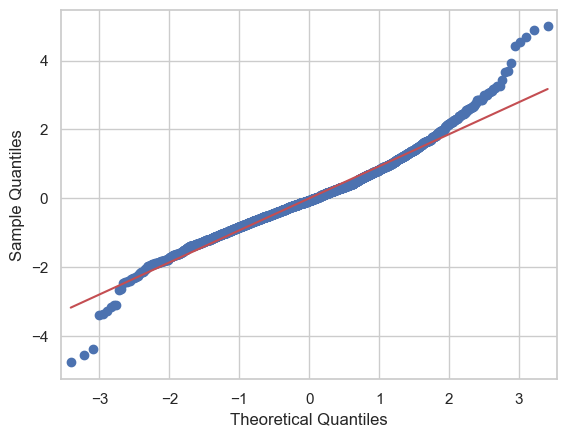

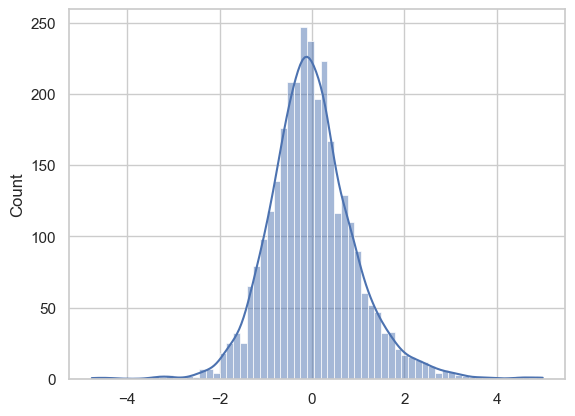

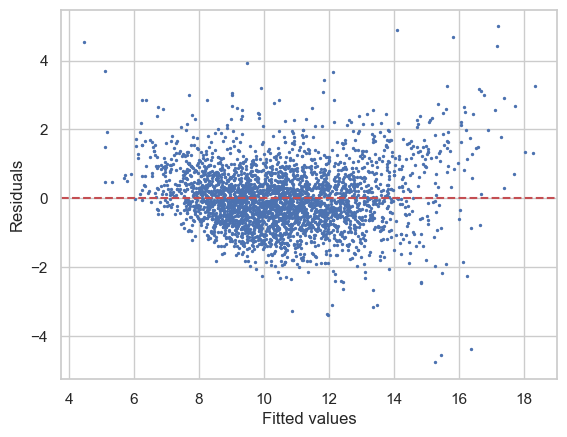

Mean Absolute Error: 0.6969937258527665
Root Mean Squared Error: 0.9308337808368066


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,10.564,0.017,628.326,"10.531 , 10.597",10.531,10.597
1,structural_internet_adoption,-0.201,0.007,-27.676,"-0.215 , -0.186",-0.215,-0.186
2,pct_hlth_unins,0.078,0.006,12.619,"0.066 , 0.091",0.066,0.091
3,brfss_checkup_ageadjprv,0.049,0.006,8.358,"0.038 , 0.061",0.038,0.061
4,brfss_csmoking_ageadjprv,-0.192,0.015,-12.974,"-0.221 , -0.163",-0.221,-0.163
5,brfss_mhlth_ageadjprv,0.299,0.016,18.546,"0.268 , 0.331",0.268,0.331
6,brfss_obesity_ageadjprv,0.129,0.007,19.530,"0.116 , 0.142",0.116,0.142
7,pct_age_gte65,-0.097,0.005,-19.792,"-0.106 , -0.087",-0.106,-0.087
8,pct_tp_veh_1,0.020,0.010,1.963,"0.0 , 0.039",0.0,0.039
9,pct_tp_veh_2,-0.043,0.008,-5.594,"-0.058 , -0.028",-0.058,-0.028


In [48]:
X_inter = df[intermediary]
X_inter = X_inter - X_inter.mean()
X_inter = sm.add_constant(X_inter)
y = df[primary_dv]
model = sm.OLS(y, X_inter).fit(cov_type='HC1')
results = model.summary()
#summary
print(model.summary())

#plot residuals on QQ
residuals = model.resid
fig = sm.qqplot(residuals, line='s')
plt.show()

#plot residuals on histogram
sns.histplot(residuals, kde=True)
plt.show()

#plot residuals on scatter, small dots
plt.scatter(model.fittedvalues, residuals, s=2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

mae = np.mean(np.abs(residuals))
print(f'Mean Absolute Error: {mae}')
rmse = np.sqrt(np.mean(residuals**2))
print(f'Root Mean Squared Error: {rmse}')

#dataframe with variable names, coefficients, std err, t-values, 95% CI, round to 3 decimal places, seperate CI into two columns
results = pd.DataFrame(model.params, columns=['Coef'])
results['Std Err'] = model.bse
results['t'] = model.tvalues
results['95% CI'] = model.conf_int()[0]
results['95% CI'] = results['95% CI'].round(3).astype(str) + ' , ' + model.conf_int()[1].round(3).astype(str)
results[['CI Lower', 'CI Upper']] = results['95% CI'].str.split(',', expand=True)
results = results.reset_index()
results = results.rename(columns={'index':'Variable'})
results = results.round(3)
display(results)
#export as csv named 'intermediary_results.csv'
results.to_csv('../Data Source/intermediary_results.csv', index=False)




In [31]:
fit_measures = pd.DataFrame()
fit_measures['MAE'] = [mae]
fit_measures['RMSE'] = [rmse]
fit_measures['R2'] = [model.rsquared]
fit_measures['Adj. R2'] = [model.rsquared_adj]
fit_measures['AIC'] = [model.aic]
fit_measures['BIC'] = [model.bic]
fit_measures['Log-Likelihood'] = [model.llf]
fit_measures['F-Statistic'] = [model.fvalue]
fit_measures['F-Statistic p-value'] = [model.f_pvalue]

display(fit_measures.round(2))

,MAE,RMSE,R2,Adj. R2,AIC,BIC,Log-Likelihood,F-Statistic,F-Statistic p-value
0,0.700,0.930,0.830,0.830,8308.190,8374.530,-4143.090,930.510,0.000


## Outlier Assessment and Removal 

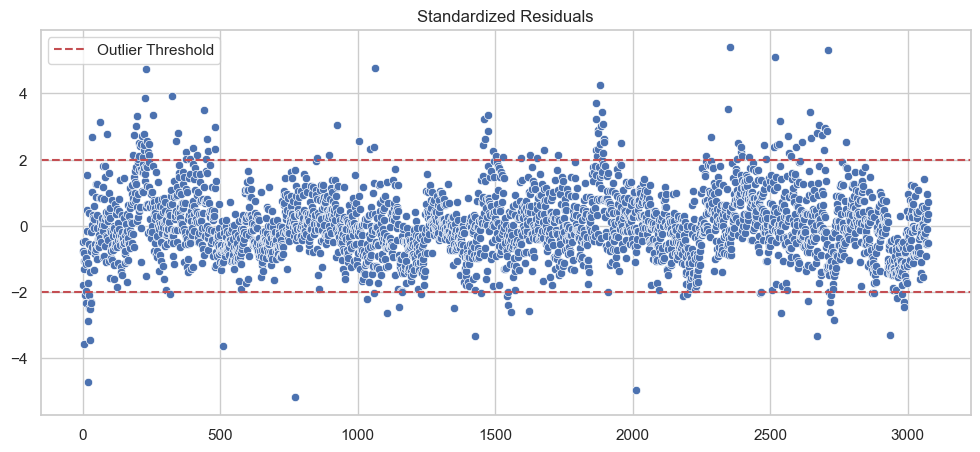

False    2860
True      216
Name: outliers, dtype: int64

0.0013003901170351106
3076


In [32]:
#outlier detection Cook's Distance
influence = OLSInfluence(model)
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance

plt.figure(figsize=(12, 5))
sns.scatterplot(x=range(len(standardized_residuals)), y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.legend()
plt.show()

df_outliers = df.copy()
df_outliers['standardized_residuals'] = standardized_residuals
df_outliers['leverage'] = leverage
df_outliers['cooks_d'] = cooks_d[0]

#identify outliers using Cook's Distance 4/(n-k-1)
df_outliers['outliers'] = df_outliers['cooks_d'] > (4/(len(df_outliers)-len(intermediary)-1))
df_outliers[df_outliers['outliers'] == True]
display(df_outliers['outliers'].value_counts())

print(4/len(df_outliers))
print(len(df_outliers))


In [33]:
# remove outliers
df_no_outliers = df_outliers[df_outliers['outliers'] == False]
#drop outlier columns
df_no_outliers = df_no_outliers.drop(columns=['standardized_residuals', 'leverage', 'cooks_d', 'outliers'])
# set x and y with outliers removed
X = df_no_outliers[intermediary]
y = df_no_outliers[primary_dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

                       Results: Ordinary least squares
Model:               OLS                       Adj. R-squared:      0.871    
Dependent Variable:  brfss_diabetes_ageadjprv  AIC:                 6259.6594
Date:                2024-04-19 10:02          BIC:                 6325.2038
No. Observations:    2860                      Log-Likelihood:      -3118.8  
Df Model:            10                        F-statistic:         1683.    
Df Residuals:        2849                      Prob (F-statistic):  0.00     
R-squared:           0.872                     Scale:               0.52047  
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
const                        10.3967   0.0135 770.6955 0.0000 10.3703 10.4232
structural_internet_adoption -0.1752   0.0054 -32.1706 0.0000 -0.1859 -0.1645
pct_hlth_

,VIF,Tolerance,features
0,1.000,1.000,const
1,4.850,0.210,structural_internet_adoption
2,1.410,0.710,pct_hlth_unins
3,1.460,0.680,brfss_checkup_ageadjprv
4,6.220,0.160,brfss_csmoking_ageadjprv
5,3.440,0.290,brfss_mhlth_ageadjprv
6,2.320,0.430,brfss_obesity_ageadjprv
7,1.240,0.810,pct_age_gte65
8,10.870,0.090,pct_tp_veh_1
9,3.880,0.260,pct_tp_veh_2


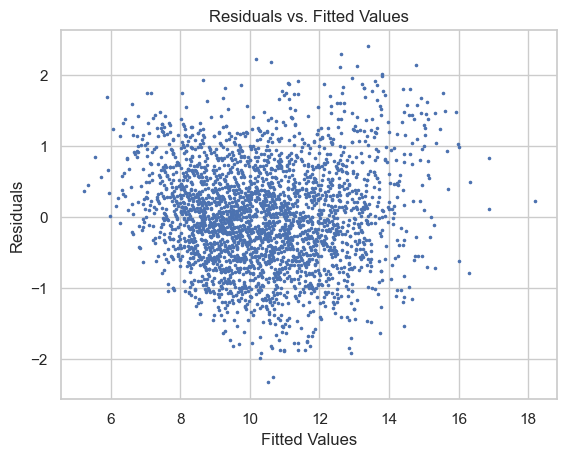

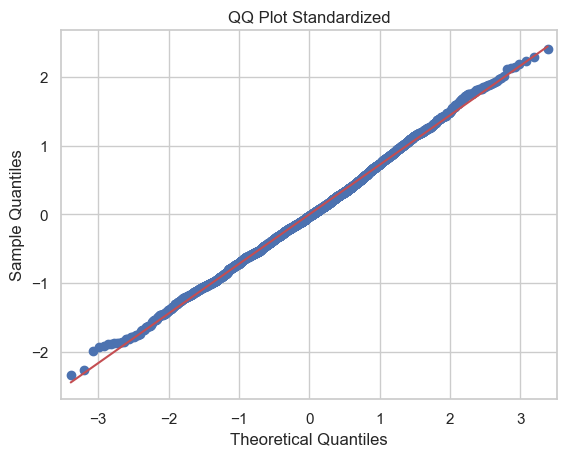

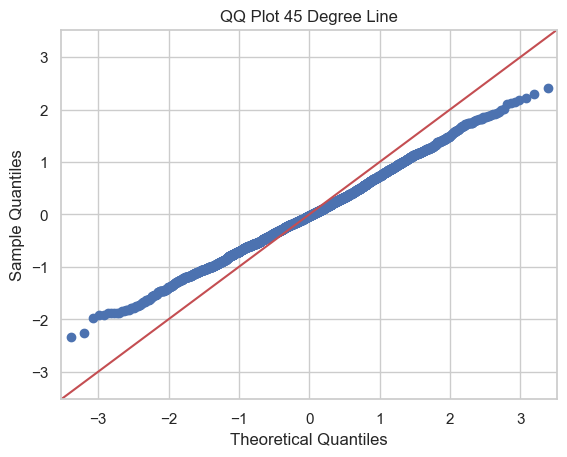

In [34]:
model = sm.OLS(y, X)
results = model.fit(cov_type='HC1')

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [35]:
fit_measures_2 = pd.DataFrame()
fit_measures_2['MAE'] = [mae]
fit_measures_2['RMSE'] = [rmse]
fit_measures_2['R2'] = [results.rsquared]
fit_measures_2['Adj. R2'] = [results.rsquared_adj]
fit_measures_2['AIC'] = [results.aic]
fit_measures_2['BIC'] = [results.bic]
fit_measures_2['Log-Likelihood'] = [results.llf]
fit_measures_2['F-statistic'] = [results.fvalue]
fit_measures_2['F-statistic p-value'] = [results.f_pvalue]

print('OLS')
display(fit_measures.round(2))
print('OLS with outliers removed')
display(fit_measures_2.round(2))

OLS


,MAE,RMSE,R2,Adj. R2,AIC,BIC,Log-Likelihood,F-Statistic,F-Statistic p-value
0,0.700,0.930,0.830,0.830,8308.190,8374.530,-4143.090,930.510,0.000


OLS with outliers removed


,MAE,RMSE,R2,Adj. R2,AIC,BIC,Log-Likelihood,F-statistic,F-statistic p-value
0,0.570,0.720,0.870,0.870,6259.660,6325.200,-3118.830,1683.230,0.000
